# Machine Learning 2 Project

In [94]:
# !pip install kagglehub
# !pip install tensorflow
# !pip install tensorflow-gpu


In [95]:
import kagglehub
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import os
import re
import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import math
import time
import tensorflow as tf
from tensorflow.keras.layers import GRU, LSTM, Bidirectional, Dense, Flatten, Conv1D, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras import Sequential
from pickle import load
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
#import statsmodels.api as sm
from math import sqrt
from datetime import datetime, timedelta
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from pickle import dump
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata

import warnings
warnings.filterwarnings("ignore")

stock_name = 'AMZN'
# Download the dataset
filtered_df = pd.read_csv('final_dataset_indexes.csv')

# Print the total number of tweets
total_rows = len(filtered_df)
print(f"Total number of rows in the dataset: {total_rows}")

#filtered_df = dataset[dataset['Stock Name'] == stock_name]
filtered_df

Total number of rows in the dataset: 2016


,Date,Open,High,Low,Close,Volume,Stock Name,Z_Score_Normalized,MA7,MA20,MACD,20SD,upper_band,lower_band,EMA,logmomentum
0,2021-09-30,260.333344,263.043335,258.333344,258.493347,53868000,TSLA,0.003853,NaN,NaN,-1.839996,NaN,NaN,NaN,258.493347,5.550994
1,2021-10-01,259.466675,260.260010,254.529999,258.406677,51094200,TSLA,0.708987,NaN,NaN,-1.751664,NaN,NaN,NaN,258.428345,5.550657
2,2021-10-04,265.500000,268.989990,258.706665,260.510010,91449900,TSLA,0.473943,NaN,NaN,-1.826312,NaN,NaN,NaN,259.869497,5.558795
3,2021-10-05,261.600006,265.769989,258.066681,260.196655,55297800,TSLA,-0.936325,NaN,NaN,-1.634578,NaN,NaN,NaN,260.090329,5.557587
4,2021-10-06,258.733337,262.220001,257.739990,260.916656,43898400,TSLA,-0.701281,NaN,NaN,-0.934345,NaN,NaN,NaN,260.643490,5.560361
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011,2022-09-23,18.000000,18.209999,17.420000,17.639999,39484400,NIO,-0.466236,19.608571,19.5170,0.061878,1.589290,22.695580,16.338420,17.954225,2.811809
2012,2022-09-26,17.770000,18.400000,17.530001,17.620001,42024500,NIO,-0.701281,19.052857,19.4020,0.188659,1.640968,22.683935,16.120065,17.731409,2.810607
2013,2022-09-27,18.180000,18.230000,16.980000,17.190001,40675200,NIO,-0.113669,18.630000,19.2710,0.189200,1.709816,22.690633,15.851367,17.370470,2.784394
2014,2022-09-28,16.799999,17.459999,16.660000,17.330000,37295600,NIO,-0.231191,18.120000,19.1460,0.398865,1.757517,22.661035,15.630965,17.343490,2.793004


In [96]:
# We drop the useless columns: date because the past for each day is embedded in the technical financial datapoints
filtered_df.dropna(inplace=True)
# removing technical indicators 
filtered_df = filtered_df.drop(columns=['MA7', 'MA20','20SD','EMA'])

#filtered_df
filtered_df


,Date,Open,High,Low,Close,Volume,Stock Name,Z_Score_Normalized,MACD,upper_band,lower_band,logmomentum
19,2021-10-27,346.553345,356.959991,343.593323,345.953339,115579500,TSLA,4.117135,-6.873491,341.251886,226.407117,5.843409
20,2021-10-28,356.103333,360.333344,351.399994,359.013336,81639600,TSLA,1.179077,-9.269895,354.015698,223.695304,5.880570
21,2021-10-29,360.619995,371.736664,357.736664,371.333344,89755200,TSLA,2.119255,-10.609662,367.635649,221.368019,5.914404
22,2021-11-01,381.666656,403.250000,372.886658,402.863342,168146100,TSLA,1.296599,-11.860446,387.433479,215.805523,5.996112
23,2021-11-02,386.453339,402.863342,382.000000,390.666656,128213400,TSLA,2.001733,-14.295169,400.300312,215.985690,5.965292
...,...,...,...,...,...,...,...,...,...,...,...,...
2011,2022-09-23,18.000000,18.209999,17.420000,17.639999,39484400,NIO,-0.466236,0.061878,22.695580,16.338420,2.811809
2012,2022-09-26,17.770000,18.400000,17.530001,17.620001,42024500,NIO,-0.701281,0.188659,22.683935,16.120065,2.810607
2013,2022-09-27,18.180000,18.230000,16.980000,17.190001,40675200,NIO,-0.113669,0.189200,22.690633,15.851367,2.784394
2014,2022-09-28,16.799999,17.459999,16.660000,17.330000,37295600,NIO,-0.231191,0.398865,22.661035,15.630965,2.793004


In [97]:
def tech_ind(dataset):
    fig,ax = plt.subplots(figsize=(15, 8), dpi = 200)
    x_ = range(3, dataset.shape[0])
    x_ = list(dataset.index)

    scaler = MinMaxScaler(feature_range=(-1, 1))

    c1 = scaler.fit_transform(dataset[['Sentiment_Numeric']])
    c2 = scaler.fit_transform(dataset[['Close']])
#     c1 = (c1 - c1.min()) / (c1.max() - c1.min())
#     c2 = (c2 - c2.min()) / (c2.max() - c2.min())

    ax.plot(dataset['Date'], c1, label='Sentiment_Numeric', color='g', linestyle='--')

#     ax.plot(dataset['Date'], dataset['MA7'], label='Moving Average (7 days)', color='g', linestyle='--')
    ax.plot(dataset['Date'], c2, label='Close', color='#6A5ACD')
#     ax.plot(dataset['Date'], dataset['MA20'], label='Moving Average (20 days)', color='r', linestyle='-.')
    ax.xaxis.set_major_formatter(DateFormatter("%Y"))
#     plt.title('Technical indicators')
    plt.ylabel('Normalized Value')
    plt.xlabel("Year")
    plt.legend()

    plt.savefig('closing_vs_sentscore.png')

    plt.show()

#tech_ind(filtered_df)

In [98]:
print(filtered_df.shape)


(1861, 12)


The entire DataFrame is copied to data to ensure that all columns are normalized. The target column (the one we want to predict is considered apart).

Two instances of MinMaxScaler are created:
- X_scaler for normalizing all features.
- y_scaler for normalizing only the target column.

In [99]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
import numpy as np
import matplotlib.pyplot as plt
from pickle import dump, load


# Convert the 'Date' column to datetime if it exists
# Extract 'month' and 'day' from the date
filtered_df['Date'] = pd.to_datetime(filtered_df['Date'])
#filtered_df['month'] = filtered_df['Date'].dt.month
#filtered_df['day'] = filtered_df['Date'].dt.day
filtered_df = filtered_df.drop(columns=['Date'])

dataset = filtered_df
print(dataset)
test_stock = 'AMZN'

unique_values = dataset["Stock Name"].unique()
print(unique_values)

# Split the dataset into training and testing sets
train_dataset = dataset[dataset['Stock Name'] != test_stock]  # All stocks except the test stock
test_dataset = dataset[(dataset['Stock Name'] == test_stock)]  # Test stock, July to December

# Drop the 'Stock Name' column
train_dataset = train_dataset.drop(columns=['Stock Name'])
test_dataset = test_dataset.drop(columns=['Stock Name'])

# Separate features (X) and target (y) in the training set
X_train_full = train_dataset.drop(columns=['Close'])
y_train_full = train_dataset['Close']

X_train, X_test, y_train, y_test = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42
)

# Define the normalize_data function
def normalize_data(df, feature_range):
    """
    Normalize data using MinMaxScaler.
    Parameters:
    - df: DataFrame object
    - feature_range: tuple -> (lower_bound, upper_bound)
    Returns:
    - X_scale_dataset: Scaled dataset as a numpy array
    """
    data = pd.DataFrame(df.iloc[:, :])
    X_scaler = MinMaxScaler(feature_range=feature_range)
    X_scaler.fit(data)
    X_scale_dataset = X_scaler.transform(data)
    dump(X_scaler, open('X_scaler.pkl', 'wb'))
    return X_scale_dataset


# Define the normalize_target function
def normalize_target(df, feature_range):
    """
    Normalize the target variable.
    Parameters:
    - df: pandas Series or DataFrame (target column, e.g., 'Close').
    - feature_range: tuple -> (lower_bound, upper_bound), e.g., (0, 1).
    Returns:
    - y_scale_dataset: Numpy array containing the normalized target values.
    """
    if isinstance(df, pd.Series):
        data = df.to_frame()
    elif isinstance(df, pd.DataFrame):
        data = df
    else:
        raise ValueError("Input to normalize_target must be a pandas Series or DataFrame")
    
    y_scaler = MinMaxScaler(feature_range=feature_range)
    y_scale_dataset = y_scaler.fit_transform(data)
    dump(y_scaler, open('y_scaler.pkl', 'wb'))
    return y_scale_dataset


# Normalize the data
X_train_normalized = normalize_data(X_train, (0, 1))
y_train_normalized = normalize_target(y_train, (0, 1))

X_test_normalized = normalize_data(test_dataset.drop(columns=['Close']), (0, 1))
y_test_normalized = normalize_target(test_dataset['Close'], (0, 1))

#X_val_normalized = normalize_data(X_val, (0, 1))
#y_val_normalized = normalize_target(y_val, (0,1))
# Define the plotting function
def plot_test_data_custom(y_test_normalized, predictions_normalized, y_scaler):
    """
    Plot the real stock prices vs. predicted prices scaled to their real values.
    Parameters:
    - y_test_normalized: Numpy array of normalized real stock prices (test set).
    - predictions_normalized: Numpy array of normalized predicted stock prices.
    - y_scaler: MinMaxScaler object used to normalize the target variable.
    Returns:
    - None
    """
    # Scale back to real values using the inverse_transform method
    y_test_real = y_scaler.inverse_transform(y_test_normalized)
    predictions_real = y_scaler.inverse_transform(predictions_normalized.reshape(-1, 1))

    # Calculate metrics
    mae = mean_absolute_error(y_test_real, predictions_real)
    mse = mean_squared_error(y_test_real, predictions_real)
    rmse = np.sqrt(mse)

    # Print metrics
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

    # Plot the results
    plt.figure(figsize=(12, 6))
    plt.plot(y_test_real, label='Real Stock Prices', marker='o')
    plt.plot(predictions_real, label='Predicted Stock Prices', marker='x')
    plt.title('Real vs. Predicted Stock Prices')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.grid(True)
    plt.savefig("TESLA.png", dpi=300, bbox_inches='tight')
    plt.show()


# Example usage for plotting:
# Load the saved scaler
y_scaler = load(open('y_scaler.pkl', 'rb'))

# Example predictions (Replace with actual predictions from your model)
# predictions_normalized = model.predict(X_test_normalized)

# Uncomment the line below once predictions are available
# plot_test_data_custom(y_test_normalized, predictions_normalized, y_scaler)


            Open        High         Low       Close     Volume Stock Name  \
19    346.553345  356.959991  343.593323  345.953339  115579500       TSLA   
20    356.103333  360.333344  351.399994  359.013336   81639600       TSLA   
21    360.619995  371.736664  357.736664  371.333344   89755200       TSLA   
22    381.666656  403.250000  372.886658  402.863342  168146100       TSLA   
23    386.453339  402.863342  382.000000  390.666656  128213400       TSLA   
...          ...         ...         ...         ...        ...        ...   
2011   18.000000   18.209999   17.420000   17.639999   39484400        NIO   
2012   17.770000   18.400000   17.530001   17.620001   42024500        NIO   
2013   18.180000   18.230000   16.980000   17.190001   40675200        NIO   
2014   16.799999   17.459999   16.660000   17.330000   37295600        NIO   
2015   16.830000   16.940001   15.370000   15.580000   51517700        NIO   

      Z_Score_Normalized       MACD  upper_band  lower_band  lo

## Random Forest algorithm

The rf_param_grid dictionary specifies a range of hyperparameter values to test:
- n_estimators: Number of trees in the forest.
- max_depth: Maximum depth of each tree (None means no limit).
- min_samples_split: Minimum number of samples required to split an internal node.
- min_samples_leaf: Minimum number of samples required to be at a leaf node.

GridSearchCV is initialized with:
- Model: RandomForestRegressor(random_state=42) (ensures reproducibility).
- Parameter Grid: rf_param_grid.
- Cross-Validation (cv=5): Splits the data into 5 folds for cross-validation.
- Scoring Metric: neg_mean_squared_error (negative MSE; smaller is better).

The fit method trains multiple Random Forest models using all combinations of hyperparameter values in rf_param_grid.
Cross-validation evaluates each combination. The best combination of hyperparameters (minimizing the negative MSE) is automatically chosen and we use it to make the predictions.

At the leaf nodes (where splitting stops), the prediction is typically the mean of the target values in that leaf

Random Forest - Best Params: {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Mean Absolute Error (MAE): 5.38
Mean Squared Error (MSE): 38.55
Root Mean Squared Error (RMSE): 6.21


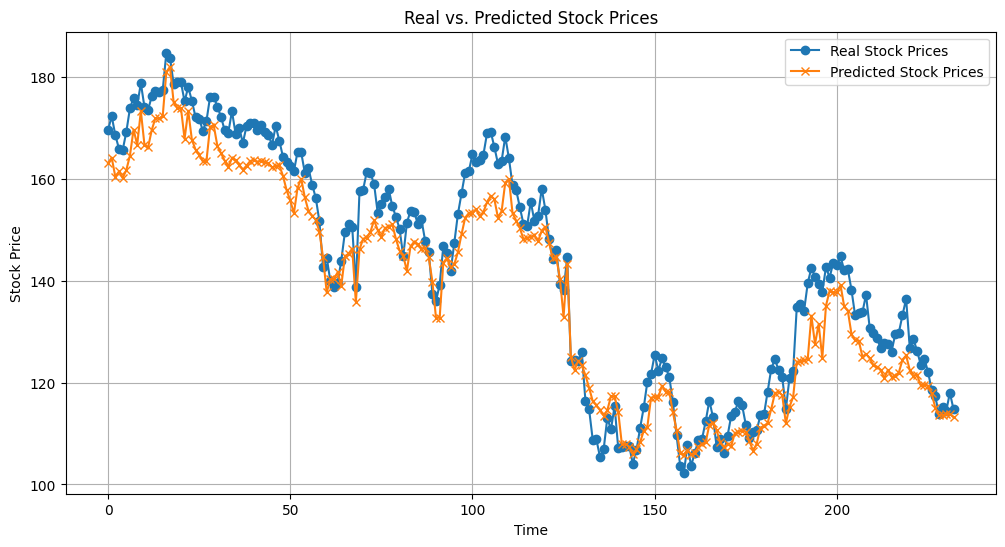

In [100]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from pickle import load

# Define Random Forest parameter grid (as a dictionary)
rf_param_grid = {
    'n_estimators': [100, 300],
    'max_depth': [10, 15, 20],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 5],
    'max_features': ['sqrt'],
    'bootstrap': [True]
}

# Initialize and fit GridSearchCV for Random Forest
rf_grid = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42, oob_score=True),  # Base model
    param_grid=rf_param_grid,  # Hyperparameter grid
    cv=5,  # 5-fold cross-validation
    scoring='neg_mean_squared_error'  # Scoring metric
)

# Fit GridSearchCV
rf_grid.fit(X_train_normalized, y_train_normalized)

# Retrieve best model and predictions
best_rf_model = rf_grid.best_estimator_

best_rf_model.fit(X_train_normalized, y_train_normalized)

rf_predictions = best_rf_model.predict(X_test_normalized)

# Output best parameters
print(f'Random Forest - Best Params: {rf_grid.best_params_}')

# Load the saved y_scaler object
y_scaler = load(open('y_scaler.pkl', 'rb'))

# Plot results
plot_test_data_custom(y_test_normalized, rf_predictions, y_scaler)


In [101]:
# CANCEL THIS CELL
'''
import numpy as np

# Check for NaNs in NumPy arrays
print("NaNs in X_train:", np.isnan(X_train).sum())
print("NaNs in X_test:", np.isnan(X_test).sum())

# Locate rows with NaNs
nan_rows_indexes = np.where(np.isnan(X_train))[0]
print("NaN locations in X_train:", nan_rows_indexes)

# Example: Assuming your array is named `data_array`
X_train_clean = X_train[~np.isnan(X_train).any(axis=1)]

print("Original shape X:", X_train.shape)
print("Cleaned shape X:", X_train_clean.shape)
y_train_clean = np.delete(y_train, nan_rows_indexes, axis=0)

print("Original shape y:", y_train.shape)
print("Cleaned shape y:", y_train_clean.shape)
'''

'\nimport numpy as np\n\n# Check for NaNs in NumPy arrays\nprint("NaNs in X_train:", np.isnan(X_train).sum())\nprint("NaNs in X_test:", np.isnan(X_test).sum())\n\n# Locate rows with NaNs\nnan_rows_indexes = np.where(np.isnan(X_train))[0]\nprint("NaN locations in X_train:", nan_rows_indexes)\n\n# Example: Assuming your array is named `data_array`\nX_train_clean = X_train[~np.isnan(X_train).any(axis=1)]\n\nprint("Original shape X:", X_train.shape)\nprint("Cleaned shape X:", X_train_clean.shape)\ny_train_clean = np.delete(y_train, nan_rows_indexes, axis=0)\n\nprint("Original shape y:", y_train.shape)\nprint("Cleaned shape y:", y_train_clean.shape)\n'

## Linear regression algorithm

Ridge regression is simply Linear regression with one key hyperparameter, alpha:
- Controls the amount of regularization applied to the model.
- Smaller values (e.g., 0.1) reduce regularization, making the model closer to standard linear regression.
- Larger values (e.g., 100) increase regularization, penalizing large coefficients to prevent overfitting.

In [102]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
from pickle import load

# Initialize Linear Regression Model
lr_model = LinearRegression()

# Define K-Fold Cross-Validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform Cross-Validation on Training Data
cv_mse_scores = cross_val_score(
    lr_model,
    X_val_normalized,
    y_val_normalized,
    scoring='neg_mean_squared_error',  # Scoring metric
    cv=kfold
)

# Convert negative MSE to positive values
cv_mse_scores = -cv_mse_scores
cv_rmse_scores = np.sqrt(cv_mse_scores)  # Convert to RMSE

# Print Cross-Validation Metrics
print("Cross-Validation Results:")
print(f"Mean MSE: {np.mean(cv_mse_scores):.4f}")
print(f"Mean RMSE: {np.mean(cv_rmse_scores):.4f}")
print(f"RMSE Std Dev: {np.std(cv_rmse_scores):.4f}")

# Train the model on the entire training data
lr_model.fit(X_train_normalized, y_train_normalized)

# Predictions on training data
y_train_predictions = lr_model.predict(X_train_normalized)

# Predictions on test data
y_test_predictions = lr_model.predict(X_test_normalized)

# Calculate training data errors
train_rmse = np.sqrt(mean_squared_error(y_train_normalized, y_train_predictions))
train_mse = mean_squared_error(y_train_normalized, y_train_predictions)
train_mae = mean_absolute_error(y_train_normalized, y_train_predictions)

# Print training data error metrics
print("\nTraining Data Errors:")
print(f"RMSE: {train_rmse:.4f}, MSE: {train_mse:.4f}, MAE: {train_mae:.4f}")

# Load the saved y_scaler object
y_scaler = load(open('y_scaler.pkl', 'rb'))

# Plot test data results
#plot_test_data_custom(y_test_normalized, y_test_predictions, y_scaler)


NameError: name 'X_val_normalized' is not defined

### Overfitting
The significant disparity between the extremely low training errors (RMSE: 0.0026) and much higher test errors (RMSE: 1.16) indicates overfitting, as the model performs well on training data but fails to generalize to unseen data; we will address this issue using regularization techniques to improve model generalization.

### Ridge Regression Model

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import LeaveOneOut

# Define alpha values
alpha_values = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]

# Initialize lists to store errors
train_rmse = []
train_mse = []
train_mae = []
test_rmse = []
test_mse = []
test_mae = []

# Leave-One-Out Cross-Validation (LOOCV)
loo = LeaveOneOut()
n_splits = loo.get_n_splits(X_train_clean)

# Train and evaluate Ridge Regression model for different alphas
for alpha in alpha_values:
    model = Ridge(alpha=alpha)

    # Initialize metrics for LOOCV
    loo_train_errors = []
    loo_test_errors = []

    for train_idx, test_idx in loo.split(X_train_clean):
        X_train, X_test = X_train_clean[train_idx], X_train_clean[test_idx]
        y_train, y_test = y_train_clean[train_idx], y_train_clean[test_idx]

        # Train model
        model.fit(X_train, y_train)

        # Predict and calculate errors for LOOCV
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Collect errors for this LOOCV split
        loo_train_errors.append(mean_squared_error(y_train, y_train_pred))
        loo_test_errors.append(mean_squared_error(y_test, y_test_pred))

    # Average the errors across all LOOCV splits
    avg_train_mse = np.mean(loo_train_errors)
    avg_test_mse = np.mean(loo_test_errors)

    # Compute RMSE and MAE for reporting
    train_rmse.append(np.sqrt(avg_train_mse))
    train_mse.append(avg_train_mse)
    train_mae.append(np.mean(np.abs(np.array(loo_train_errors))))

    test_rmse.append(np.sqrt(avg_test_mse))
    test_mse.append(avg_test_mse)
    test_mae.append(np.mean(np.abs(np.array(loo_test_errors))))

# Print results
for i, alpha in enumerate(alpha_values):
    print(f"Alpha: {alpha}")
    print(f"Training RMSE: {train_rmse[i]:.4f}, MSE: {train_mse[i]:.4f}, MAE: {train_mae[i]:.4f}")
    print(f"Test RMSE: {test_rmse[i]:.4f}, MSE: {test_mse[i]:.4f}, MAE: {test_mae[i]:.4f}")
    print("-" * 50)

# Plot errors
plt.figure(figsize=(10, 6))

# RMSE plot
plt.plot(alpha_values, train_rmse, label='Train RMSE', marker='o')
plt.plot(alpha_values, test_rmse, label='Test RMSE', marker='o')
plt.xscale('log')
plt.xlabel('Alpha (log scale)')
plt.ylabel('RMSE')
plt.title('Root Mean Squared Error vs Alpha')
plt.legend()
plt.grid(True)
plt.show()

# MSE plot
plt.figure(figsize=(10, 6))
plt.plot(alpha_values, train_mse, label='Train MSE', marker='o')
plt.plot(alpha_values, test_mse, label='Test MSE', marker='o')
plt.xscale('log')
plt.xlabel('Alpha (log scale)')
plt.ylabel('MSE')
plt.title('Mean Squared Error vs Alpha')
plt.legend()
plt.grid(True)
plt.show()

# MAE plot
plt.figure(figsize=(10, 6))
plt.plot(alpha_values, train_mae, label='Train MAE', marker='o')
plt.plot(alpha_values, test_mae, label='Test MAE', marker='o')
plt.xscale('log')
plt.xlabel('Alpha (log scale)')
plt.ylabel('MAE')
plt.title('Mean Absolute Error vs Alpha')
plt.legend()
plt.grid(True)
plt.show()


## Best Alpha

**α=0.001** strikes the best balance:

- **Training RMSE**: **0.0026**  
- **Test RMSE**: **0.0027**

The error gap is minimal, and both values are extremely low, indicating excellent generalization without signs of overfitting or underfitting. The model performs almost equally well on both the training and test data.

A slightly larger alpha (**α=0.01**) marginally increases both training and test errors:  
- **Training RMSE**: **0.0028**  
- **Test RMSE**: **0.0029**  
This suggests that stronger regularization slightly hinders the model's ability to capture underlying patterns.

For much larger alphas (**α=10** and above), the training and test errors increase significantly:  
- **For α=10**: **Training RMSE: 0.0139**, **Test RMSE: 0.0140**  
This indicates underfitting, as excessive regularization reduces the model's ability to learn relationships in the data.

### Conclusion

The optimal value is **α=0.001**, as it achieves the lowest errors while maintaining a good balance between training and test performance.

## K-Nearest Neighbors regression algorithm

Creates a KNN regression model with the hyperparameter n_neighbors=5:
- Specifies that the model will use the 5 nearest neighbors to make predictions.
- The predicted value for a data point is typically the average of the target values of its 5 nearest neighbors.

A higher value of n_neighbors leads to smoother predictions (more averaging), which may reduce variance but increase bias.
A lower value captures finer details in the data but risks overfitting.

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

# KNN algorithm
knn = KNeighborsRegressor(n_neighbors=5)  # Adjust n_neighbors as needed
knn.fit(X_train_clean, y_train_clean)

# Step 4: Make Predictions
knn_predictions = knn.predict(X_test)

plot_test_data_custom(y_test, knn_predictions)